# NLP Project

## Business Understanding

- This analysis uses tweets gathered from SXSW 2013 and attempts to predict customer sentiment toward Apple and Google products.
- Consumer sentiment toward brands can provide insight into the motivations behind their purchasing behaviors.

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import RandomOverSampler

## Data Understanding

### Overview
- Source: https://data.world/crowdflower/brands-and-product-emotions
- Human raters evaluated 9K tweets and rated the sentiment as positive, negative, or no emotion.
- The tweets were gathered from the 2013 South by Southwest Festival, a festival centered around art, music, and new technology.
- Target: positive, negative, & neutral sentiment

### Data Cleaning

In [2]:
# import data
df = pd.read_csv("data/brands_and_product_tweets.csv")

# rename columns for readability
df = df.rename(columns = {'tweet_text': 'tweet',
                          'emotion_in_tweet_is_directed_at': 'product',
                          'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Sentiment labels were renamed to positive, negative, neutral, or unclear for easier readability.

In [3]:
# rename sentiment labels
df['sentiment'] = df['sentiment'].replace({"No emotion toward brand or product": "neutral",
                                           "Positive emotion": "positive",
                                           "Negative emotion": "negative",
                                           "I can't tell": "unclear"})
df['sentiment'].value_counts()

neutral     5156
positive    2869
negative     545
unclear      151
Name: sentiment, dtype: int64

In [4]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [5]:
# explore null values
df.isna().sum()

tweet           1
product      5539
sentiment       0
dtype: int64

In [6]:
# drop rows with null 'tweet'
df.dropna(subset=['tweet'], inplace=True)

In [7]:
# fill null 'product' with 'unassigned'
df['product'].fillna('unassigned', inplace = True)

# view distribution of product labels
df['product'].value_counts()

unassigned                         5538
iPad                                909
Apple                               638
iPad or iPhone App                  450
Google                              410
iPhone                              287
Other Google product or service     282
Android App                          77
Android                              73
Other Apple product or service       34
Name: product, dtype: int64

In [8]:
# rename some product labels
df['product'] = df['product'].replace({"Other Google product or service": "Other Google",
                                       "Other Apple product or service": "Other Apple"})
df['product'].value_counts()

unassigned            5538
iPad                   909
Apple                  638
iPad or iPhone App     450
Google                 410
iPhone                 287
Other Google           282
Android App             77
Android                 73
Other Apple             34
Name: product, dtype: int64

In [9]:
# categorize products by brand

# create column 'brand' with default value 'NA'
df['brand'] = 'NA'

# define conditions using 'product' name
product_apple = df['product'].str.contains('apple|ip', case=False)
product_google = df['product'].str.contains('google|android', case=False)

# fill in 'brand' using defined conditions
df.loc[product_apple, 'brand'] = 'apple'
df.loc[product_google, 'brand'] = 'google'

# view distribution of of brand labels
df.groupby(['brand', 'product']).size()

brand   product           
NA      unassigned            5538
apple   Apple                  638
        Other Apple             34
        iPad                   909
        iPad or iPhone App     450
        iPhone                 287
google  Android                 73
        Android App             77
        Google                 410
        Other Google           282
dtype: int64

In [10]:
df.head()

,tweet,product,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google


In [11]:
df.brand.value_counts()

NA        5538
apple     2318
google     842
Name: brand, dtype: int64

In [12]:
### WIP ###

# define function to identify brand mentioned in tweet text
#def tweet_brand(row):
#    tweet_apple = df['tweet'].str.contains('apple|iphone|ipad', case=False)
#    tweet_google = df['tweet'].str.contains('google|android', case=False)
    
#    if row['brand'] == 'NA':
#        if tweet_apple.any() and tweet_google.any():
#            return 'both'
#        elif tweet_apple.any():
#            return 'apple'
#        elif tweet_google.any():
#            return 'google'
    
#        return row['brand']

# apply the function to each row and return results to 'brand'
#df['brand'] = df.apply(tweet_brand, axis=1)


#df['brand'].value_counts()
#df.groupby(['brand', 'product']).size()

In [13]:
# reset index after dropping rows
df.reset_index(drop=True, inplace=True)
df

,tweet,product,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google
...,...,...,...,...
8693,Ipad everywhere. #SXSW {link},iPad,positive,apple
8694,"Wave, buzz... RT @mention We interrupt your re...",unassigned,neutral,NA
8695,"Google's Zeiger, a physician never reported po...",unassigned,neutral,NA
8696,Some Verizon iPhone customers complained their...,unassigned,neutral,NA


In [73]:
# Filter the DataFrame for negative sentiments
negative_tweets = df[df['sentiment'] == 'negative']

# Display the resulting DataFrame or extract the 'tweet' column
negative_tweets['tweet'].head(20)

0      .@wesley83 I have a 3G iPhone. After 3 hrs twe...
3      @sxsw I hope this year's festival isn't as cra...
16     I just noticed DST is coming this weekend. How...
37     @mention  - False Alarm: Google Circles Not Co...
61     Again? RT @mention Line at the Apple store is ...
64     attending @mention iPad design headaches #sxsw...
65     Boooo! RT @mention Flipboard is developing an ...
89     What !?!? @mention  #SXSW does not provide iPh...
100    Know that &quot;dataviz&quot; translates to &q...
162    Seriously #sxsw? Did you do any testing on the...
164    ipad2 and #sxsw...a conflagration of doofusnes...
172    You spent $1,000+ to come to SXSW. \n\nYou've ...
181    I'm up to 2 iPad 2s seen in the wild. Both peo...
223    If iPhone alarms botch the timechange, how man...
226    I meant I also wish I  at #SXSW #dyac stupid i...
Name: tweet, dtype: object

In [75]:
# Filter the DataFrame for negative sentiments
neutral_tweets = df[df['sentiment'] == 'neutral']

# Display the resulting DataFrame or extract the 'tweet' column
neutral_tweets['tweet'].head(20)

5     @teachntech00 New iPad Apps For #SpeechTherapy...
15    Holler Gram for iPad on the iTunes App Store -...
31    Attn: All  #SXSW frineds, @mention Register fo...
32        Anyone at  #sxsw want to sell their old iPad?
33    Anyone at  #SXSW who bought the new iPad want ...
34    At #sxsw.  Oooh. RT @mention Google to Launch ...
36    SPIN Play - a new concept in music discovery f...
38    VatorNews - Google And Apple Force Print Media...
40    HootSuite - HootSuite Mobile for #SXSW ~ Updat...
41    Hey #SXSW - How long do you think it takes us ...
42    Mashable! - The iPad 2 Takes Over SXSW [VIDEO]...
43    For I-Pad ?RT @mention New #UberSocial for #iP...
46    Orly....? ���@mention Google set to launch new...
48    Khoi Vinh (@mention says Conde Nast's headlong...
49    ���@mention {link} &lt;-- HELP ME FORWARD THIS...
50    ��� WHAT? ��_ {link} ��_ #edchat #musedchat #s...
51    .@mention @mention on the location-based 'fast...
52    ���@mention @mention #Google Will Connect 

In [76]:
df.tweet[8697]

'�ϡ�����_��ʋ�\u038b�ҋ�������⋁_��������_���RT @mention Google Tests ���Check-in Offers�\u06dd At #SXSW {link}'

### Data Visualization

In [14]:
# function to build countplot for specified columns

def tweet_countplot(df, col, hue=None):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(data=df, x=col, hue=hue, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'distribution of tweets by {col}')
    plt.show()


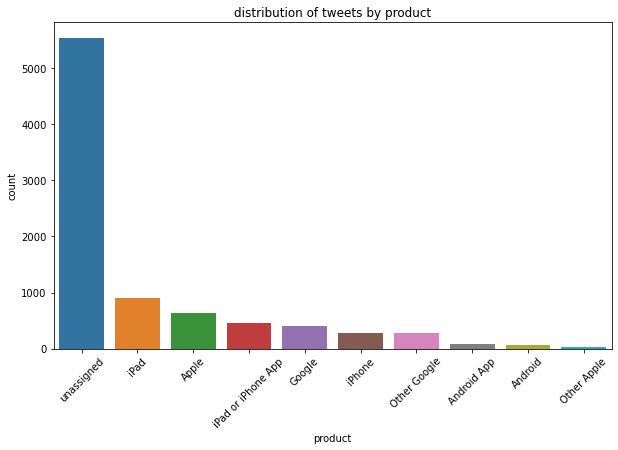

In [15]:
tweet_countplot(df, 'product')

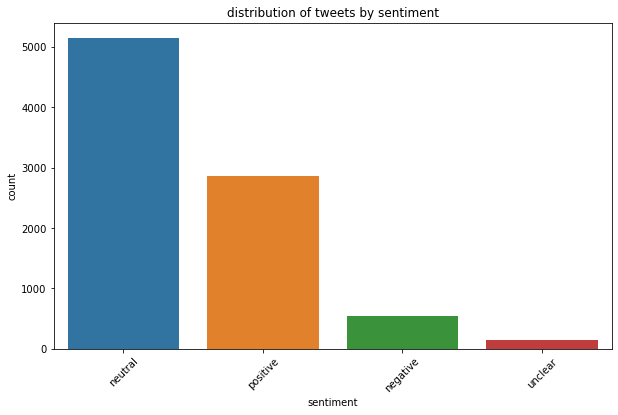

In [16]:
tweet_countplot(df, 'sentiment')

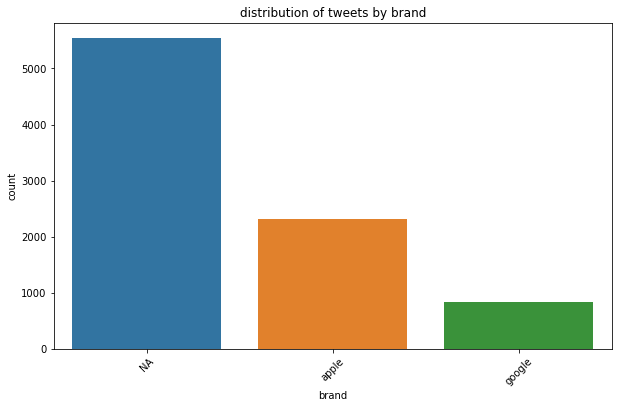

<Figure size 432x288 with 0 Axes>

In [17]:
tweet_countplot(df, 'brand')
plt.savefig('images/tweets_by_brand.png', bbox_inches='tight')
plt.show();

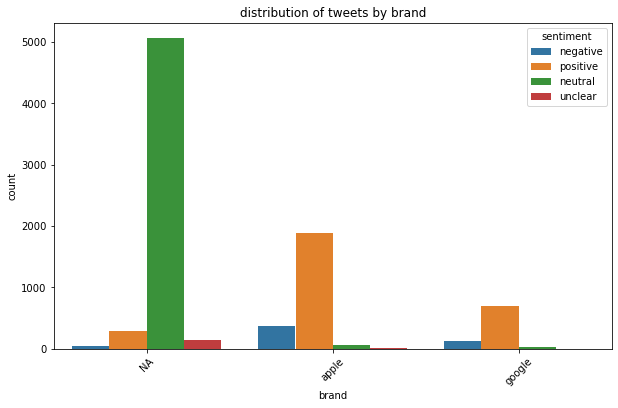

In [18]:
tweet_countplot(df, 'brand', hue='sentiment')

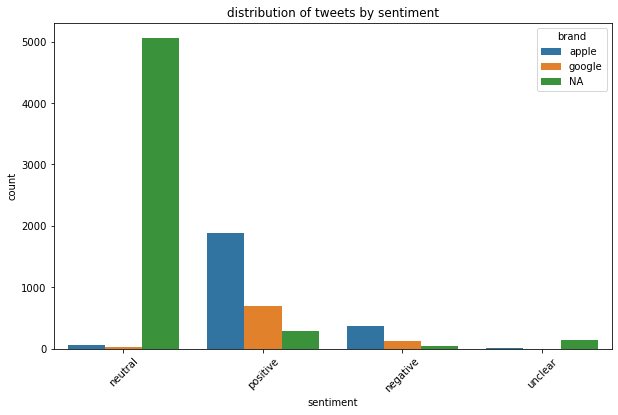

In [19]:
tweet_countplot(df, 'sentiment', hue='brand')

## Binary Preprocessing

In [42]:
df2 = pd.read_csv('data/brands_and_product_tweets.csv', encoding='ISO-8859-1')

In [43]:
df2.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [46]:
def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english')) | {'sxsw','link','rt'}
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Clean the tweet_text column
df2['cleaned_tweet_text'] = df2['tweet_text'].apply(clean_text)

In [47]:
df2['cleaned_tweet_text'].head(30)

0     g iphone hrs tweeting rise austin dead need up...
1     know awesome ipad iphone app likely appreciate...
2                                   wait ipad also sale
3         hope year's festival crashy year's iphone app
4     great stuff fri marissa mayer google tim o'rei...
5     new ipad apps speechtherapy communication show...
6                                                      
7     starting ctia around corner googleio hop skip ...
8     beautifully smart simple idea wrote hollergram...
9     counting days plus strong canadian dollar mean...
10    excited meet show sprint galaxy still running ...
11    find amp start impromptu parties can't wait ti...
12    foursquare ups game time still prefer far best...
13    gotta love google calendar featuring top parti...
14                                       great ipad app
15               haha awesomely rad ipad app hollergram
16                holler gram ipad itunes app store via
17    noticed dst coming weekend many iphone use

In [48]:
# Map textual sentiment labels to numerical values
sentiment_mapping = {
    "Positive emotion": 1,
    "Negative emotion": -1,
    "No emotion": 0,
    "I can't tell": None  # You might choose to exclude these or handle them differently
}

# Apply the mapping to your sentiment label column
df2['sentiment_label'] = df2['is_there_an_emotion_directed_at_a_brand_or_product'].map(sentiment_mapping)

# Drop rows where 'sentiment_label' is NaN
df2 = df2.dropna(subset=['sentiment_label'])

# Check the first few rows to ensure the mapping is applied correctly
print(df2[['is_there_an_emotion_directed_at_a_brand_or_product', 'sentiment_label']].head())

  is_there_an_emotion_directed_at_a_brand_or_product  sentiment_label
0                                   Negative emotion             -1.0
1                                   Positive emotion              1.0
2                                   Positive emotion              1.0
3                                   Negative emotion             -1.0
4                                   Positive emotion              1.0


In [50]:
df2.sentiment_label.value_counts()

 1.0    2869
-1.0     545
Name: sentiment_label, dtype: int64

In [51]:
# Assuming 'clean_text' is your preprocessing function and 'tweet_text' is the column to preprocess
df2['cleaned_text'] = df2['tweet_text'].apply(clean_text)

# Drop rows with NaN values in 'sentiment_label' after mapping but before vectorization
df2 = df2.dropna(subset=['sentiment_label'])

# Now vectorize your cleaned text

vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df2['cleaned_text'])

In [52]:
df2['cleaned_tweet_text'].head(10)

0     g iphone hrs tweeting rise austin dead need up...
1     know awesome ipad iphone app likely appreciate...
2                                   wait ipad also sale
3         hope year's festival crashy year's iphone app
4     great stuff fri marissa mayer google tim o'rei...
7     starting ctia around corner googleio hop skip ...
8     beautifully smart simple idea wrote hollergram...
9     counting days plus strong canadian dollar mean...
10    excited meet show sprint galaxy still running ...
11    find amp start impromptu parties can't wait ti...
Name: cleaned_tweet_text, dtype: object

In [53]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

 
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Example text
example_text = "Fall Out Boy Rules."

# Lemmatize the example text
# Apply lemmatization to the DataFrame column
df2['lemmatized_text'] = df2['cleaned_tweet_text'].apply(lemmatize_text)

# Print the first few rows of the 'lemmatized_text' column to verify the output
print(df['lemmatized_text'].head())

0    g iphone hr tweeting rise austin dead need upg...
1    know awesome ipad iphone app likely appreciate...
2                                  wait ipad also sale
3      hope year 's festival crashy year 's iphone app
4    great stuff fri marissa mayer google tim o'rei...
Name: lemmatized_text, dtype: object


In [55]:
# Initialize the CountVectorizer
count_vect = CountVectorizer()

# Fit and transform the 'lemmatized_text' column
X_counts = count_vect.fit_transform(df2['lemmatized_text'])

# Convert the result to a DataFrame to view the token counts
count_vect_df = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names())
print(count_vect_df.head())

   aapl  abacus  abandoned  aber  ability  able  absolute  absolutely  abt  \
0     0       0          0     0        0     0         0           0    0   
1     0       0          0     0        0     0         0           0    0   
2     0       0          0     0        0     0         0           0    0   
3     0       0          0     0        0     0         0           0    0   
4     0       0          0     0        0     0         0           0    0   

   abuzz  ...  zimride  zing  zip  zite  zms  zombie  zomg  zone  zoom  zzzs  
0      0  ...        0     0    0     0    0       0     0     0     0     0  
1      0  ...        0     0    0     0    0       0     0     0     0     0  
2      0  ...        0     0    0     0    0       0     0     0     0     0  
3      0  ...        0     0    0     0    0       0     0     0     0     0  
4      0  ...        0     0    0     0    0       0     0     0     0     0  

[5 rows x 5101 columns]


In [56]:
# Sum up the counts for each word across all documents
word_counts = count_vect_df.sum(axis=0)

# Sort the word counts in descending order to get the most frequent words
top_15_words = word_counts.sort_values(ascending=False).head(15)

# Display the top 25 words and their counts
print(top_15_words)

ipad       1405
apple      1020
google      852
iphone      690
quot        625
store       586
app         444
new         395
austin      313
amp         225
pop         220
android     219
get         199
launch      188
one         168
dtype: int64


### Binary Modeling

In [57]:
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    X_counts, 
    df2['sentiment_label'], 
    test_size=0.2,  # 80% training and 20% testing
    random_state=42  # Ensures a reproducible split
)

### Logistic Regression

A logistic regression model was used to take a look at just the positive & negative tweets.\

In [59]:
#initialize model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_log_train, y_log_train)

# Predict on the test set
y_log_pred = logreg.predict(X_log_test)

# Evaluate the model
print("Accuracy on Testing Set:", accuracy_score(y_log_test, y_log_pred))
print(classification_report(y_log_test, y_log_pred))


Accuracy on Testing Set: 0.8726207906295754
              precision    recall  f1-score   support

        -1.0       0.80      0.32      0.46       115
         1.0       0.88      0.98      0.93       568

    accuracy                           0.87       683
   macro avg       0.84      0.65      0.69       683
weighted avg       0.87      0.87      0.85       683



In [60]:
# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset for balanced classes
X_resampled, y_resampled = ros.fit_resample(X_log_train, y_log_train)

In [62]:
# Initialize model with class weights
logreg2 = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg2.fit(X_resampled, y_resampled)

y_pred_logreg2 = logreg2.predict(X_log_test)

print("Updated Accuracy on Testing Set:", accuracy_score(y_log_test, y_pred_logreg2))
print(classification_report(y_log_test, y_pred_logreg2))

Updated Accuracy on Testing Set: 0.8682284040995608
              precision    recall  f1-score   support

        -1.0       0.63      0.54      0.58       115
         1.0       0.91      0.93      0.92       568

    accuracy                           0.87       683
   macro avg       0.77      0.74      0.75       683
weighted avg       0.86      0.87      0.86       683



''

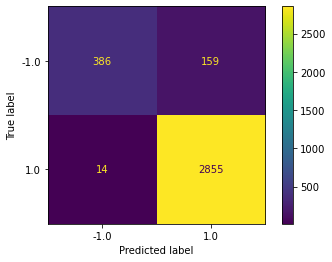

In [65]:
plot_confusion_matrix(logreg, X_counts, df2['sentiment_label'])
;

## Multiclass Preprocessing

In [20]:
def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    #stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in sw])
    
    return text

# Clean the tweet_text column
#df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

In [21]:
tknzr = RegexpTokenizer(r"(?u)\w{3,}")
tweet_tknzr = TweetTokenizer(strip_handles=True)

lemmer = WordNetLemmatizer()

#p_stemmer = PorterStemmer()
#s_stemmer = SnowballStemmer()

sw = stopwords.words('english')
new_sw = ['sxsw','link', 'rt']
sw.extend(new_sw)

In [22]:
# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each word
    lemmatized_tokens = [lemmer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [23]:
df['sentiment'].value_counts()

neutral     5142
positive    2861
negative     544
unclear      151
Name: sentiment, dtype: int64

In [33]:
# Map textual sentiment labels to numerical values
sentiment_mapping = {
    "neutral": 0,
    "positive": 1,
    "negative": -1,
    "unclear": 0  # You might choose to exclude these or handle them differently
}

# Apply the mapping to your sentiment label column
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

# Drop rows where 'sentiment_label' is NaN
df = df.dropna(subset=['sentiment_label'])

# Check the first few rows to ensure the mapping is applied correctly
df['sentiment_label'].value_counts()

 0    5293
 1    2861
-1     544
Name: sentiment_label, dtype: int64

In [34]:
df['cleaned_text'] = df['tweet'].apply(clean_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8698 entries, 0 to 8697
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            8698 non-null   object
 1   product          8698 non-null   object
 2   sentiment        8698 non-null   object
 3   brand            8698 non-null   object
 4   sentiment_label  8698 non-null   int64 
 5   cleaned_text     8698 non-null   object
 6   lemmatized_text  8698 non-null   object
dtypes: int64(1), object(6)
memory usage: 543.6+ KB


### Multiclass Vectorizing

In [35]:
# instantiate CountVectorizer
count_vect = CountVectorizer()

# fit and transform lemmatized text
count_matrix = count_vect.fit_transform(df['lemmatized_text'])

# convert count matrix to a DataFrame
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vect.get_feature_names())

count_df

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Display the frequency table
freq_table = count_df.sum(axis=0).sort_values(ascending=False).reset_index()
freq_table.columns = ['Term', 'Frequency']
freq_table

,Term,Frequency
0,ipad,2891
1,google,2539
2,apple,2218
3,quot,1621
4,iphone,1529
...,...,...
8160,luxury,1
8161,lwr,1
8162,lybian,1
8163,lyfe,1


In [37]:
#instantiate TF-IDF vectorizer
tf_vect = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
tf = tf_vect.fit_transform(df.lemmatized_text)

tf_vect_df = pd.DataFrame(tf.toarray(), columns=tf_vect.get_feature_names())
tf_vect_df

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Concatenate count_df and tf_vect_df along the columns
combined_df = pd.concat([count_df, tf_vect_df], axis=1)

# Drop duplicate columns
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

In [39]:
combined_df.head()

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,r,sxsw'ers,tv'ed,u,v,w,x,y'all,y'day,z
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Multiclass Modeling


In [32]:
# train test split
X = combined_df
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Multinomial Naive Bayes

A Multinomial Naive Bayes model was used. In terms of overfitting, this model did the best, but was not as accurate on testing data as the random forest.

In [67]:
# multinomial naive bayes
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)


MultinomialNB()

In [68]:
y_pred_mnb = mnb_model.predict(X_test)
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

          -1       0.38      0.23      0.28       115
           0       0.73      0.75      0.74      1040
           1       0.55      0.57      0.56       585

    accuracy                           0.65      1740
   macro avg       0.55      0.51      0.53      1740
weighted avg       0.65      0.65      0.65      1740



In [69]:
print("Accuracy on Training Set: ", accuracy_score(y_train, mnb_model.predict(X_train)))
print("Accuracy on Testing Set: ", accuracy_score(y_test, mnb_model.predict(X_test)))

Accuracy on Training Set:  0.8123023857430296
Accuracy on Testing Set:  0.653448275862069


''

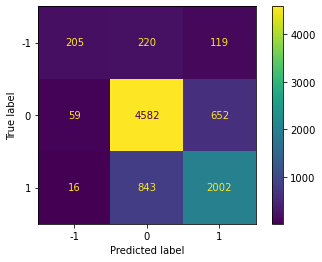

In [71]:
plot_confusion_matrix(mnb_model, X, y)
;

### Decision Tree

A Decision Tree was another model we looked at, which was, unsurprisingly, very overfit due to the nature of decision trees. We picked a decision tree because they are very useful with complex & multiclass problems.

In [93]:
# decision tree

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [97]:
y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

          -1       0.44      0.35      0.39       115
           0       0.71      0.79      0.75      1040
           1       0.61      0.52      0.56       585

    accuracy                           0.67      1740
   macro avg       0.59      0.55      0.57      1740
weighted avg       0.66      0.67      0.66      1740



In [119]:
print("Accuracy on Training Set: ", accuracy_score(y_train, dt_model.predict(X_train)))
print("Accuracy on Testing Set: ", accuracy_score(y_test, dt_model.predict(X_test)))

Accuracy on Training Set:  0.9601897096866916
Accuracy on Testing Set:  0.6689655172413793


''

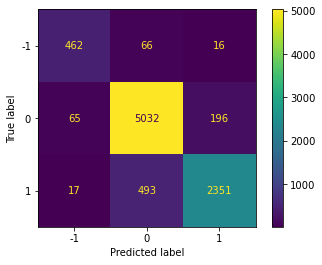

In [123]:
plot_confusion_matrix(dt_model, X, y)
;

A random forest model was also used. We expected this model to be overfit, as random forests tend to be. Please see this notebook for GridSearchCVs for optimizing hyperparameters.

In [110]:
# random forest
rf = RandomForestClassifier(random_state=42, min_samples_split=20, n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=42)

In [111]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

          -1       0.85      0.20      0.32       115
           0       0.69      0.90      0.78      1040
           1       0.69      0.43      0.53       585

    accuracy                           0.70      1740
   macro avg       0.75      0.51      0.55      1740
weighted avg       0.70      0.70      0.67      1740



In [120]:
print("Accuracy on Training Set: ", accuracy_score(y_train, rf.predict(X_train)))
print("Accuracy on Testing Set: ", accuracy_score(y_test, rf.predict(X_test)))

Accuracy on Training Set:  0.9202356999137683
Accuracy on Testing Set:  0.6959770114942528


''

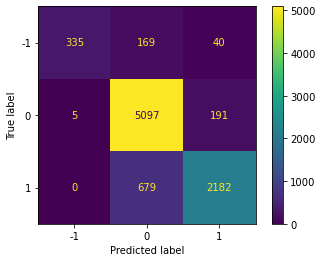

In [124]:
plot_confusion_matrix(rf, X, y)
;

The final RandomForest model ended up with around a 70% accuracy on the testing data, after starting off around 64% accurate. The min_samples_split was updated to 20 & the n_estimators was updated to 150. The overfitting of the random forest started to decrease with adjustments of hyperparameters.

### Evaluation Metrics
- false positives - classify as customer likes the product when they do not 
- false negatives - classify as customer does not like product when they do

We used the accuracy score for our metrics since we wanted to decrease the amount of both false positives & negatives in our calculations.

## Final Models

We had a binary & a multiclass final model: the logistic regression & the random forest. We can't quite compare these two, since it's similar to comparing orange to apples. The logistic regression was quite a bit more accurate in predicting which tweets were positive or negative, even using a balanced weight class. 

## Recommendations

- further analyze negative tweets
- improve future devices
- analyze why there are more tweets about Apple (potentially having to do with their popup at SXSW 2013)
- encourage popup stores for other companies
- improve model by further customizing the data & tuning the models
    - hyperparameter tuning, more GridSearches, which can be very time consuming